In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, norm
from pympler.asizeof import asizeof
import sklearn.neural_network
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import os

/home/zigon/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
TYPES = 7
T = 100
GENE_NAMES = ['n', 'a_a', 'b_a', 'a_d', 'b_d', 'axon', 'dend', 'tau', 'to']
RANGE = ((5, 10, 60), 
         (-1, 0.4, 2.6), 
         (0.5, 0.5, 2.5), 
         (-1, 0.4, 2.6), 
         (0.5, 0.5, 2.5), 
         (-1, 2, 1), 
         (-1, 2, 1), 
         (5, 10, 100))
POOL = [np.arange(lo, hi+d, d) for (lo, d, hi) in RANGE]
POOL[0] = POOL[0].astype(np.int32)
POOL[1] = np.abs(POOL[1])
POOL[3] = np.abs(POOL[3])

In [ ]:
TYPE_HOLD = 0.4 # Pr(this type won't mutate)
GENE_HOLD = 0.5 # Pr(this gene won't mutate | this type can mutate)
DUP = 0.4 # Pr(duplicate)
DEL = 0.4 # Pr(delete)

In [ ]:
x = np.linspace(0, 1)
av = np.abs(np.arange(-1, 2.6+0.4, step=0.4))
# av[av == 0] = 1
bv = np.arange(0.5, 2.5 + 0.5, step=0.5)
fig, ax = plt.subplots(len(av), len(bv), figsize=(8, 8))
for i, a in enumerate(av):
    for j, b in enumerate(bv):
        pdf = beta.pdf(x, a=a, b=b)
        ax[i, j].plot(x, pdf >=1)

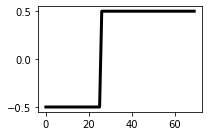

In [33]:
fig, ax = plt.subplots(figsize=(3, 2)) 
ax.plot(generate(1)[0][0], color='black', linewidth=3)
ax.set_yticks([-0.5, 0, 0.5])
fig.tight_layout()
fig.savefig('sig_ref.svg')

In [5]:
class Retina:
    def __init__(self, genome=None, randtypes=False, randproj=False):
#         self.no_connection = no_connection
        
        self.score = 0
        
        if genome is None:
            self._types = np.random.randint(3, TYPES + 1) if randtypes else 2

            self.genome = pd.DataFrame(columns=GENE_NAMES, index=np.arange(TYPES))

            for name, pool in zip(GENE_NAMES[:-1], POOL): # The 'to' gene is not included here
                # NOTE: .loc is end-inclusive
                self.genome.loc[:self._types-1, name] = \
                    np.random.choice(pool, size=self._types, replace=True)
                
            # Fixed number
            self.genome.loc[0, 'n'] = RANGE[0][-1]
            self.genome.loc[self._types-1, 'n'] = RANGE[0][0]
            
            self.randproj()
            
        else:
            self.genome = genome.copy()
            self._types = TYPES
            for i, row in genome.iterrows():
                if np.isnan(row.n):
                    self._types = i
                    break
            if randproj:
                self.randproj()
            assert len(self.genome.loc[self._types-1, 'to']) == 0
            
        self._w = np.empty((TYPES, TYPES), dtype=np.object) # Weights
        
        self._size = 0
        
        self.neurogenesis()
        
        self._size += asizeof(self)
        
        
    def randproj(self):
        for i in range(self._types - 1):
            j = i
            while j == i:
                j = np.random.randint(0, self._types)
            self.genome.to[i] = [j]

        # Fixed projection to 
        self.genome.loc[self._types-1, 'to'] = []
    
    def neurogenesis(self):
        # Location (centered), only used during neurogenesis
        # Never use unpack here: nan will occur
        loc = [np.linspace(-0.5, 0.5, num=int(self.genome.n[i]) + 2)[1:-1] 
               for i in range(self._types)]
        
        # From i to j
        for i in range(self._types): 
            for j in range(self._types):
#                 if self.no_connection(i, j, self._types): 
                if j not in self.genome.to[i]:
                    self._w[i, j] = None
                    continue
                
                dist = np.abs(loc[i][:, None] - loc[j][None, :])
                
                ws = beta.pdf(dist, a=self.genome.a_a[i], b=self.genome.b_a[i])
                wt = beta.pdf(dist, a=self.genome.a_d[j], b=self.genome.b_d[j])
                ws[ws > 1e4] = 1e4
                wt[wt > 1e4] = 1e4
                w = ws * wt
                w[w < 1] = 0
                w[w >= 1] = self.genome.axon[i] * self.genome.dend[j]
                self._w[i, j] = w
                
                self._size += asizeof(self._w[i, j])
                
    def shape_gain(self):
        s = self._types - 2
        i = len(self.genome.to[0])
        if s == 0 or i == 0:
            return i
        
        shapes = [1 - abs(len(to) - 1) / s for to in self.genome.to[1:self._types-1]]
        return np.mean(shapes)
                
    def forward(self, x):
        # Spike train; axis2 for consistency
        spikes = np.zeros((T, x.shape[0], int(self.genome.n[self._types-1])), 
                          dtype=np.float64)
        
        # Used in testing; may occupy too much memory
        s = [np.zeros((T, x.shape[0], int(self.genome.n[i])), dtype=np.float64) 
             for i in range(self._types)]
        
#         # Axis0: old and new
#         s = [np.zeros((2, x.shape[0], int(self.genome.n[i])), dtype=np.float64) 
#              for i in range(self._types)]
        
        for k in range(1, T):
            t = k # Used with s = [(T, r, n)] * types
#             t = 1 # Used with s = [(2, r, n)] * types
            
            # From i to j
            for j in range(self._types):
                # s_rest = 0.5
                # ds_j/dt = - (s_j - s_rest)
                ds = 0.5 - s[j][t-1]
                
                for i in range(self._types - 1):
                    if self._w[i, j] is None: 
                        continue
                    if (self._w[i, j] == 0).all():
                        continue
                    
                    try:
                        # ds_j/dt = sum_i(s_i @ w_ij) - (s_j - s_rest)
                        ds += s[i][t-1] @ self._w[i, j]
                    except:
                        print(self.genome) 
                        print(i, '->', j, s[i][t-1].shape, self._w[i, j].shape)
                        raise ValueError
                
                # ds_0/dt = sum_i(s_i @ w_i0) - (s_j - s_rest) + I_ext
                if j == 0:
                    ds += x
                
                # RGC: EIF neuron
                if j == self._types - 1: 
                    ds += 1e-2 * np.exp((s[j][t-1] - 0.9) / 1e-2)
                
                # dt = 1
                s[j][t] = s[j][t-1] + 1 / self.genome.tau[j] * ds
                
                # Biological threshold
                s[j][t, s[j][t] < 0] = 0
                
                if j == self._types - 1: # Check for spike
                    spikes[t, s[j][t] >= 1] = 1
                    s[j][t, s[j][t] >= 1] = 0
                else: # Biological threshold
                    s[j][t, s[j][t] > 1] = 1
                    
        return s, spikes
                   
                    
    def size(self):
        return self._size
    
    def mutation(self):
        copy = -1
        # Duplicate
        if (self._types < TYPES) and (np.random.rand() < DUP):
#             print(self.genome)
            copy = np.random.randint(0, self._types - 1)
            
            for i in range(self._types, copy, -1):
                self.genome.iloc[i] = self.genome.iloc[i-1]
                self.genome.loc[i, 'to'] = self.genome.loc[i-1, 'to'].copy()

            copy += 1 # after the original type
            self._types += 1
            
            # Increase the targets whose indices >= the value of copy
            for i in range(self._types):
                for j, v in enumerate(self.genome.loc[i, 'to']):
                    if v >= copy:
                        self.genome.loc[i, 'to'][j] += 1
            
#             print(self.genome)
            
        # Remove
        elif (self._types > 2) and (np.random.rand() < DEL):
#             print(self.genome)
            rm = np.random.randint(1, self._types - 1)

            for i in range(rm, self._types - 1):
                self.genome.iloc[i] = self.genome.iloc[i+1]
                self.genome.loc[i, 'to'] = self.genome.loc[i+1, 'to'].copy()
            
            self._types -= 1
            self.genome.iloc[self._types] = np.NaN
            
            for i in range(self._types):
                # Remove rm
                if rm in self.genome.loc[i, 'to']:
                    self.genome.loc[i, 'to'].remove(rm)
                    
                # Decrease the targets whose indices > the value of copy
                for j, v in enumerate(self.genome.loc[i, 'to']):
                    if v > rm:
                        self.genome.loc[i, 'to'][j] -= 1

#             print(self.genome)
            
        for i in range(self._types):
            if (i != copy) and (np.random.rand() < TYPE_HOLD): 
                continue # the new duplicate cannot be held

            for name, pool in zip(GENE_NAMES[:-1], POOL):
                if name == 'n': # Nest for conveniently commenting out
                    if i == 0: continue
                    if i == self._types - 1: continue
                        
                if np.random.rand() < GENE_HOLD:
                    continue 

                # Random walk with Poisson distribution
                mut = 1 if np.random.rand() < 0.5 else -1
                mut *= np.random.poisson(1) 
                mut += np.where(pool == self.genome.loc[i, name])[0][0]
                if mut >= len(pool): mut = len(pool) - 1
                if mut < 0: mut = 0

                self.genome.loc[i, name] = pool[mut]
                    
            # Mutate projection to
            if np.random.rand() >= GENE_HOLD and i != self._types - 1:                
                j = np.random.randint(0, self._types)
                if j in self.genome.to[i]:
                    del self.genome.to[i][self.genome.to[i].index(j)]
                elif j != i:
                    self.genome.to[i].append(j)

In [3]:
def generate(n=5):
    gaussian = norm.pdf(np.linspace(-1, 1, num=5))

    index = np.random.randint(0, RANGE[0][-1], size=n)
    flip = np.random.choice([True, False], size=n)
    x = np.zeros((n, RANGE[0][-1]+len(gaussian)))
    
    for i in range(n):
        if flip[i]: x[i, :index[i]] = 1
        else: x[i, index[i]:] = 1
    
#         x[i] += np.random.rand(RANGE[0][-1]+len(gaussian)) * 0.1
#         x[i, :RANGE[0][-1]] = np.convolve(x[i], gaussian, 'valid')[:-1]
    
#     x = x[:, :RANGE[0][-1]]
    
    # x in [-1, 1]
    x -= 0.5
    
#     x *= np.random.uniform(0.3, 1, size=n)[:, None]
    
    return x, index

In [8]:
RUN_PROTOTYPE = False

In [9]:
if RUN_PROTOTYPE:
    def f1(i, j, N):
        if i == N - 1: return True # Critical for removing the weights
        if i == j: return True # No internal connections

        # Feedforward scheme
        if (i != 0) and (j != N - 1): return True

        return False
    
    def f2(i, j, N):
        if i == N - 1: return True # Critical for removing the weights
        if i == j: return True # No internal connections

        # Feedforward scheme
        if (i != 0) and (j != N - 1): return True
        if (i == 0) and (j == N - 1): return True

        return False
    
    def f3(i, j, N):
        if i == N - 1: return True # Critical for removing the weights
        if i == j: return True # No internal connections

        if (i == 0) and (j == N - 1): return True
        return False

    a = Retina(randtypes=True)
    a.mutation()
    a.neurogenesis()
    x, y = generate()
    s, spikes = a.forward(x)
    print(a.genome, a.shape_gain())

In [10]:
if RUN_PROTOTYPE:
    plot_elite_generation([[a.genome.copy()]], np.zeros((1, 1)), 0, [0], f1, '_')

In [11]:
if RUN_PROTOTYPE:
    plot_elite_response([[a.genome.copy()]], 0, 0, f1, '_')

In [12]:
if RUN_PROTOTYPE:
    plot_elite_response_profile([[a.genome.copy()]], 0, -1, f1, '_')

In [8]:
GENERATIONS = 400
POPULATION = 150
ELITES = 10
TRAIN = 500
TEST = 100
SHAPE_W = 0.15
XRATE = 0.2

In [14]:
path1 = 'r_ni_%d_%d_%d_%d_1' % tuple(map(lambda x: int(x * 100), [DUP, DEL, SHAPE_W, XRATE]))
os.mkdir(path1)
# for path2 in ('fw1', 'fw2', 'free'):
#     path2 = os.path.join(path1, path2)
#     os.mkdir(path2)

In [4]:
class MLPClassifier(sklearn.neural_network.MLPClassifier):
# Overriding _init_coef method
    def _init_coef(self, fan_in, fan_out):
        if self.activation == 'logistic':
            init_bound = np.sqrt(2. / (fan_in + fan_out))
        elif self.activation in ('identity', 'tanh', 'relu'):
            init_bound = np.sqrt(6. / (fan_in + fan_out))
        else:
            raise ValueError("Unknown activation function %s" %
                             self.activation)
        coef_init = np.ones((fan_in, fan_out), dtype=np.float64) * init_bound

        intercept_init = np.ones(fan_out, dtype=np.float64) * init_bound

        return coef_init, intercept_init

In [5]:
class MLPRegressor(sklearn.neural_network.MLPRegressor):
# Overriding _init_coef method
    def _init_coef(self, fan_in, fan_out):
        if self.activation == 'logistic':
            init_bound = np.sqrt(2. / (fan_in + fan_out))
        elif self.activation in ('identity', 'tanh', 'relu'):
            init_bound = np.sqrt(6. / (fan_in + fan_out))
        else:
            raise ValueError("Unknown activation function %s" %
                             self.activation)
        coef_init = np.ones((fan_in, fan_out), dtype=np.float64) * init_bound

        intercept_init = np.ones(fan_out, dtype=np.float64) * init_bound

        return coef_init, intercept_init

In [6]:
@ignore_warnings(category=ConvergenceWarning)
def model(x, y, mode):
    if mode == 'mlp_reg':
        x = x.mean(axis=0)
        m = MLPRegressor(solver='lbfgs', alpha=1e-5, learning_rate_init=0.01, max_iter=5, 
                         hidden_layer_sizes=(x.shape[1]//2,))
        m = m.fit(x[:TRAIN], y[:TRAIN])
        
#         speed = 1 - len(m.loss_curve_) / 50
#         score = m.score(x[TRAIN:], y[TRAIN:])
        return m.score(x[TRAIN:], y[TRAIN:])
    elif mode == 'mlp_cla':
        assert x.shape[1] > 1
        x = x.mean(axis=0)
        m = MLPClassifier(solver='adam', alpha=1e-5, learning_rate_init=0.01, max_iter=5, 
                          hidden_layer_sizes=(x.shape[1]//2,))
        m = m.fit(x[:TRAIN], y[:TRAIN])
        return m.score(x[TRAIN:], y[TRAIN:])
    else:
        raise ValueError

In [18]:
def evaluation(population, x, y, mode):
    for individual in population:
        assert len(individual.genome.loc[individual._types-1, 'to']) == 0
        s, spikes = individual.forward(x)
        R2 = model(spikes, y, mode)
        shape_gain = individual.shape_gain()
        
        individual.score = (1 - SHAPE_W) * R2 + SHAPE_W * shape_gain
        
    population.sort(key=lambda n: n.score, reverse=True)

In [19]:
def child(p1, p2): # Give birth to a child
    if np.random.rand() > XRATE: # Don't crossover
        return
    
    # Randomly have a number of types
    types = np.random.randint(2, min((TYPES + 1, p1._types + p2._types - 1)))
    
    # Choose to inherit receptor cell traits from one of the parent
    p = p1 if np.random.rand() < 0.5 else p2
    genomeli = [p.genome.iloc[0]]
    
    if types > 2: # Add interneurons
        li = []
        for p in (p1, p2): # Make the pool
            if p._types > 2:
                li += [p.genome.iloc[i] for i in range(p._types)]
        indices = np.random.choice(np.arange(len(li)), size=types - 2, replace=True)
        genomeli += [li[i] for i in indices]
    
    # Choose to inherit RGC traits from one of the parent
    p = p1 if np.random.rand() < 0.5 else p2
    genomeli.append(p.genome.iloc[p._types - 1])
    assert len(genomeli[-1].to) == 0
    
    genome = pd.DataFrame(columns=GENE_NAMES, index=np.arange(TYPES))
    
    for i, g in enumerate(genomeli): # Assign back
        genome.iloc[i, :] = g.copy()
    
    assert len(genome.loc[types-1, 'to']) == 0
    
    return Retina(genome, randproj=True)

def sel_cross(population, scores, tk):
    indices = np.arange(0, POPULATION)
    children = []
    
    for i in range(ELITES, POPULATION): 
        p1s, p2s = np.random.choice(indices, replace=False, size=(2, tk))
        p = []
        
        for ps in (p1s, p2s): # Tournament selection
            s = np.array([scores[k] for k in ps])
            if s.min() < 0: 
                s -= s.min()
            if s.sum() == 0:
                s = np.ones(tk) / tk
            else:
                s /= s.sum()
            p.append(np.random.choice(ps, p=s))
        
        c = child(population[p[0]], population[p[1]])
        if c is not None: 
            assert len(c.genome.loc[c._types-1, 'to']) == 0
        children.append(c)
    
    for i in range(ELITES, POPULATION):
        if children[i-ELITES] is not None:
            population[i] = children[i-ELITES]

In [20]:
def run(mode, no_connection=None):
    # Generate the input and population
    x, y = generate(TRAIN + TEST)
    population = [Retina() for _ in range(POPULATION)]
    
    # Buffers
    scores = []
    elites = []
    breakthrough = []
    maxli = -1
    for t in range(GENERATIONS):
        if XRATE > 0 and t > 0:
            sel_cross(population, scores[t-1], 5)
            
        if t > 0:
            for i in range(ELITES, POPULATION):
                population[i].mutation()
            
                population[i].neurogenesis()
            
        evaluation(population, x, y, mode)
        
        li = list(map(lambda n: n.score, population))
        aux = max(li)
        if maxli < aux:
            if aux - maxli > 0.01:
                breakthrough.append(t)
            maxli = aux
            print(t, aux)
        
        scores.append(li)
        elites.append([population[i].genome.copy() for i in range(ELITES)])
    
    return np.array(scores), elites, breakthrough

In [21]:
def plot_evolution(scores, path):
    fig, ax = plt.subplots(2, sharex='all', figsize=(5, 5))
    ax[0].plot(scores[:, :ELITES]) 
    ax[0].set_title('Elites')

    q1, q2, q3 = np.quantile(scores, [0.25, 0.5, 0.75], axis=1)
    ax[1].plot(q2)
    ax[1].fill_between(np.arange(GENERATIONS), q1, q3, alpha=0.1) 
    ax[1].set_title('Median and IQR')
    ax[1].set_xlabel('Generation')

    fig.text(0.05, 0.6, 'Survival scores', ha='center', rotation='vertical')
    fig.savefig(os.path.join(path, 'evolution.pdf'))

In [22]:
def plot_elite_response(elites, elite_id, generation_id, path):
    a = Retina(elites[generation_id][elite_id])
    
    x, y = generate()
    s, spikes = a.forward(x)
    
    s_df = pd.DataFrame(columns=['trial', 'type', 'responses'], 
                        index=np.arange(int(x.shape[0] * (a._types + 1))))
    counter = 0
    for k in range(x.shape[0]):
        for i, si in enumerate(s):
            s_df.loc[counter, 'trial'] = k
            if i == 0:
                s_df.loc[counter, 'type'] = 'PR'
            elif i == a._types - 1:
                s_df.loc[counter, 'type'] = 'RGC'
            else:
                s_df.loc[counter, 'type'] = i
            s_df.loc[counter, 'responses'] = si[:, k].T
            counter += 1
        s_df.loc[counter, 'trial'] = k
        s_df.loc[counter, 'type'] = 'spikes'
        s_df.loc[counter, 'responses'] = spikes[:, k].T
        counter += 1

    def plot(x, color, **kwargs):
        plt.imshow(x.values[0], aspect='auto', vmin=0, vmax=1, interpolation='none')
        plt.yticks([0, len(x.values[0])])

    g = sns.FacetGrid(s_df, row='trial', col='type', sharey=False, height=2, aspect=1.5)
    g.map(plot, 'responses')
    plt.savefig(os.path.join(path, 'ellite%d_response.pdf' % elite_id))

In [20]:
def plot_elite_response_profile(elites, elite_id, generation_id, path):
    a = Retina(elites[generation_id][elite_id])
    
    n = RANGE[0][-1]
    x = np.zeros((n * 2, RANGE[0][-1]))
    
    for i in range(n):
        x[i, :i] = 1
        x[i + n, i:] = 1
        
    # x in [-1, 1]
    x -= 0.5

    s, spikes = a.forward(x)

    spikes = spikes.mean(axis=0) # rate

    spikessum = spikes.sum(axis=0)

    spikes /= spikessum[None, ...] + 1 # Normalize
    
    profile = x.T @ spikes # x by rgc
    
    d = profile.max() - profile.min()
    zeros = np.zeros(n)
    
    fig, ax = plt.subplots(1, figsize=(2.5, 5))
    for i in range(RANGE[0][0]):
        ax.plot(zeros + d * i, linewidth=1, linestyle='--', c='b')
        ax.plot(profile[:, i] + d * i)
    ax.set_yticks(np.arange(0, RANGE[0][0]) * d)
    ax.set_yticklabels(np.arange(0, RANGE[0][0]))
    ax.set_xlabel('Receptor Position')
    ax.set_ylabel('RGC Index')
    fig.tight_layout()
    
    fig.savefig(os.path.join(path, 'ellite%d_response_profile.pdf' % elite_id))

In [24]:
def from_to(i, j, N):
    li = []
    for k in (i, j):
        if k == 0:
            li.append('PR')
        elif k == N - 1:
            li.append('RGC')
        else:
            li.append(k)
    return '{} to {}'.format(*li)

In [25]:
def plot_elite_generation(elites, scores, elite_id, generations, path):
    w_all = []
    types = []
    for l in generations:
        a = Retina(elites[l][elite_id])
        w_df = [(i, j, a._w[i, j]) for i in range(TYPES) for j in range(TYPES) 
                if a._w[i, j] is not None if not (a._w[i, j] == 0).all()]
#         w_df = [(i, j, a._w[i, j]) for i in range(TYPES) for j in range(TYPES) 
#                 if not (a._w[i, j] is None) if not (a._w[i, j] == 0).all()]
        w_all.append(w_df)
        types.append(a._types)

    l = max(map(len, w_all))
    fig, ax = plt.subplots(len(w_all), l, figsize=(l * 1.5, len(generations) * 1.5))
    if len(ax.shape) == 1:
        ax = ax[None, :]
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].set_axis_off()
    
    for k, w_df in enumerate(w_all):
        txt = 'Generation %d\nScore %.3f' % (generations[k], scores[generations[k], elite_id])
        ax[k, 0].set_ylabel(txt)
        for t, (i, j, w) in enumerate(w_df):
            ax[k, t].set_axis_on()
            ax[k, t].set_title(from_to(i, j, types[k]))
            
            ax[k, t].imshow(w, cmap='seismic', vmin=-1, vmax=1, aspect='auto', interpolation='none')
            ax[k, t].set_xticks([0, w.shape[1]-1])
            ax[k, t].set_yticks([0, w.shape[0]-1])
            ax[k, t].set_xticklabels([0, w.shape[1]])
            ax[k, t].set_yticklabels([0, w.shape[0]])
            if w.shape[1] == 1:
                ax[k, t].set_xticks([])
    fig.tight_layout()
    fig.savefig(os.path.join(path, 'ellite%d_generation.pdf' % elite_id))

In [26]:
def plot_elites_final(elites, scores, path):
    w_all = []
    types = []
    for l in range(ELITES):
        a = Retina(elites[-1][l])
        w_df = [(i, j, a._w[i, j]) for i in range(TYPES) for j in range(TYPES) 
                if a._w[i, j] is not None if not (a._w[i, j] == 0).all()]
        w_all.append(w_df)
        types.append(a._types)

    l = max(map(len, w_all))
    fig, ax = plt.subplots(ELITES, l, figsize=(l * 1.5, ELITES * 1.5))
    if len(ax.shape) == 1:
        ax = ax[None, :]
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].set_axis_off()
            
    for k, w_df in enumerate(w_all):
        txt = 'Elite %d\nScore %.3f' % (k, scores[-1, k])
        ax[k, 0].set_ylabel(txt)
        for t, (i, j, w) in enumerate(w_df):
            ax[k, t].set_axis_on()
            ax[k, t].set_title(from_to(i, j, types[k]))
            
            ax[k, t].imshow(w, cmap='seismic', vmin=-1, vmax=1, aspect='auto', interpolation='none')
            ax[k, t].set_xticks([0, w.shape[1]-1])
            ax[k, t].set_yticks([0, w.shape[0]-1])
            ax[k, t].set_xticklabels([0, w.shape[1]])
            ax[k, t].set_yticklabels([0, w.shape[0]])
            if w.shape[1] == 1:
                ax[k, t].set_xticks([])
    fig.tight_layout()
    fig.savefig(os.path.join(path, 'ellite_final.pdf'))

In [27]:
scores0, elites0, breakthrough0 = run('mlp_reg', None)

0 0.14486863452752546
4 0.17651925753843428
9 0.18003126920857926
10 0.24109521839856163
13 0.27237506189549343
19 0.3242194104357072
35 0.34102278047673945
65 0.4272939797107555
280 0.5560285727928723
386 0.5667925594143547


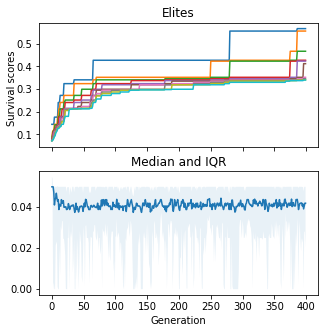

In [28]:
plot_evolution(scores0, path1)

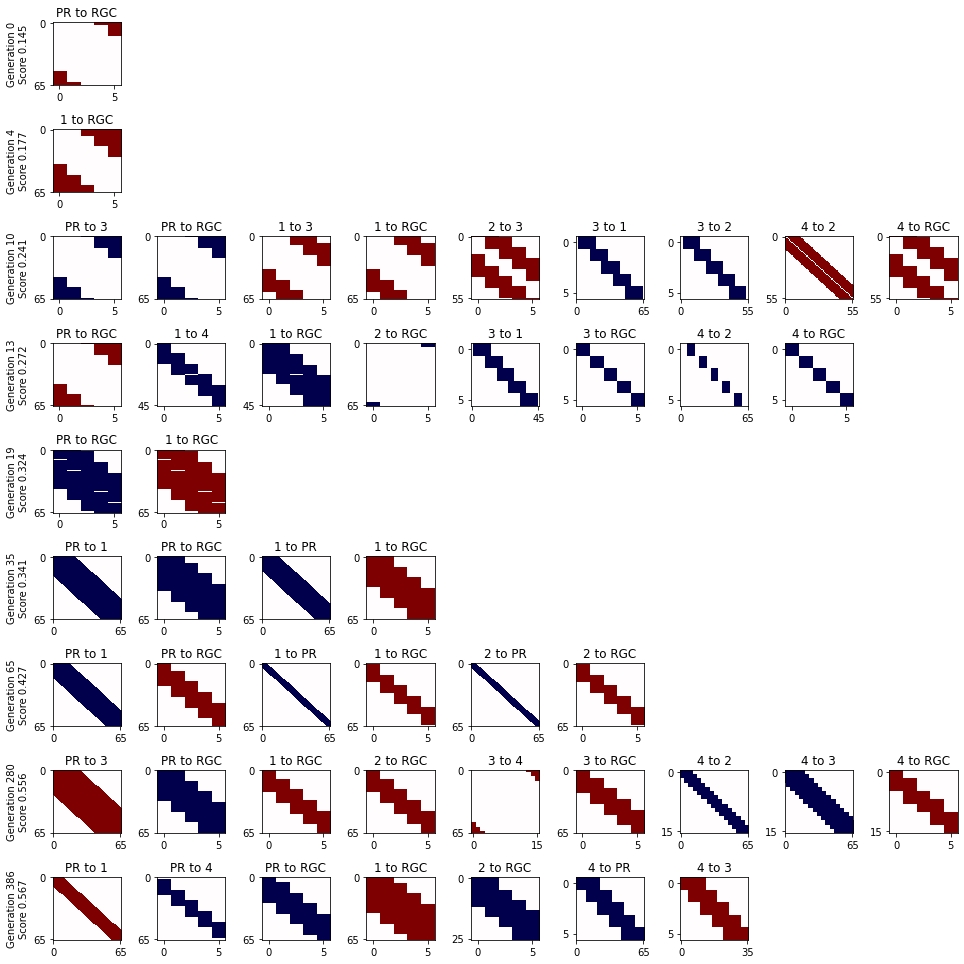

In [29]:
plot_elite_generation(elites0, scores0, 0, breakthrough0, path1)

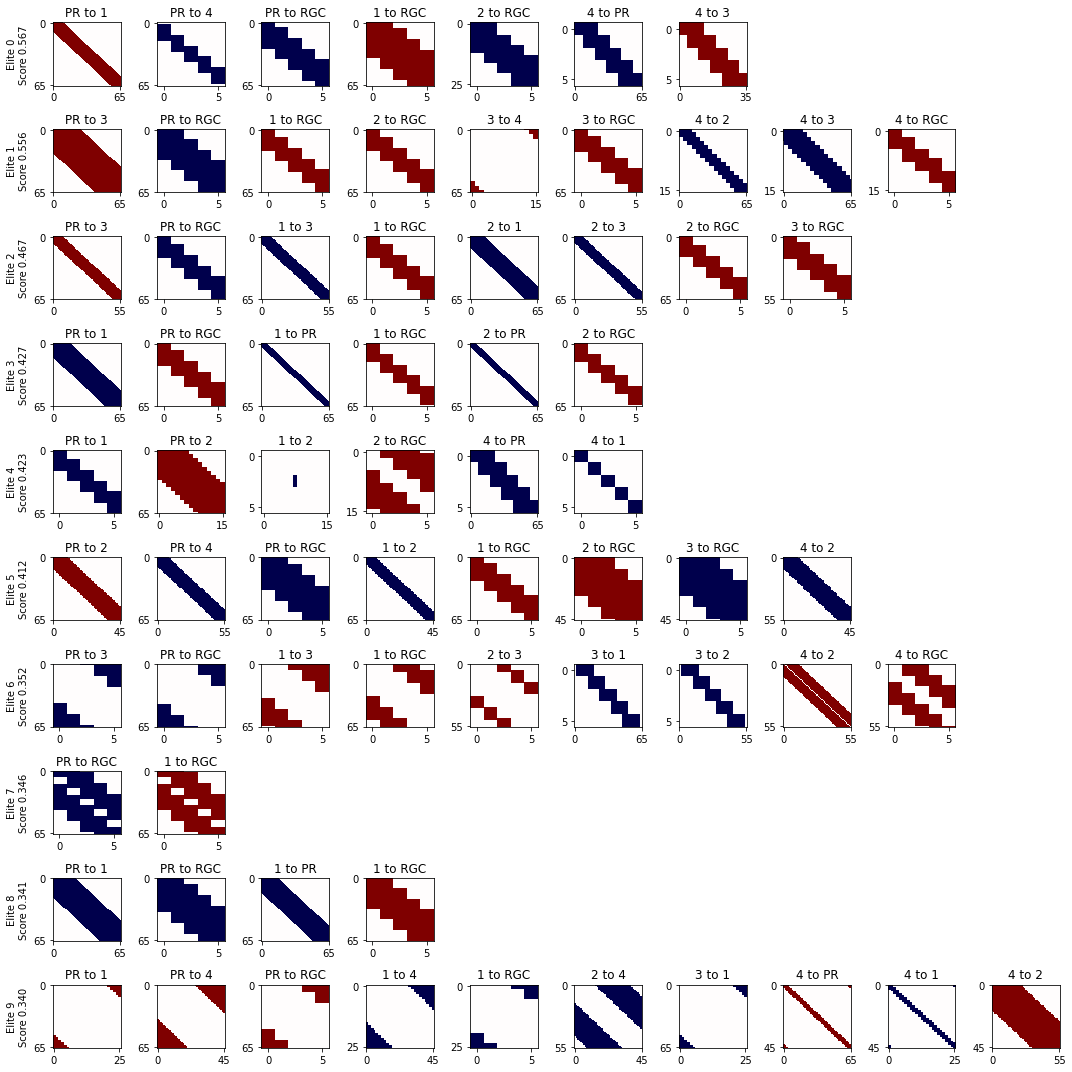

In [30]:
plot_elites_final(elites0, scores0, path1)

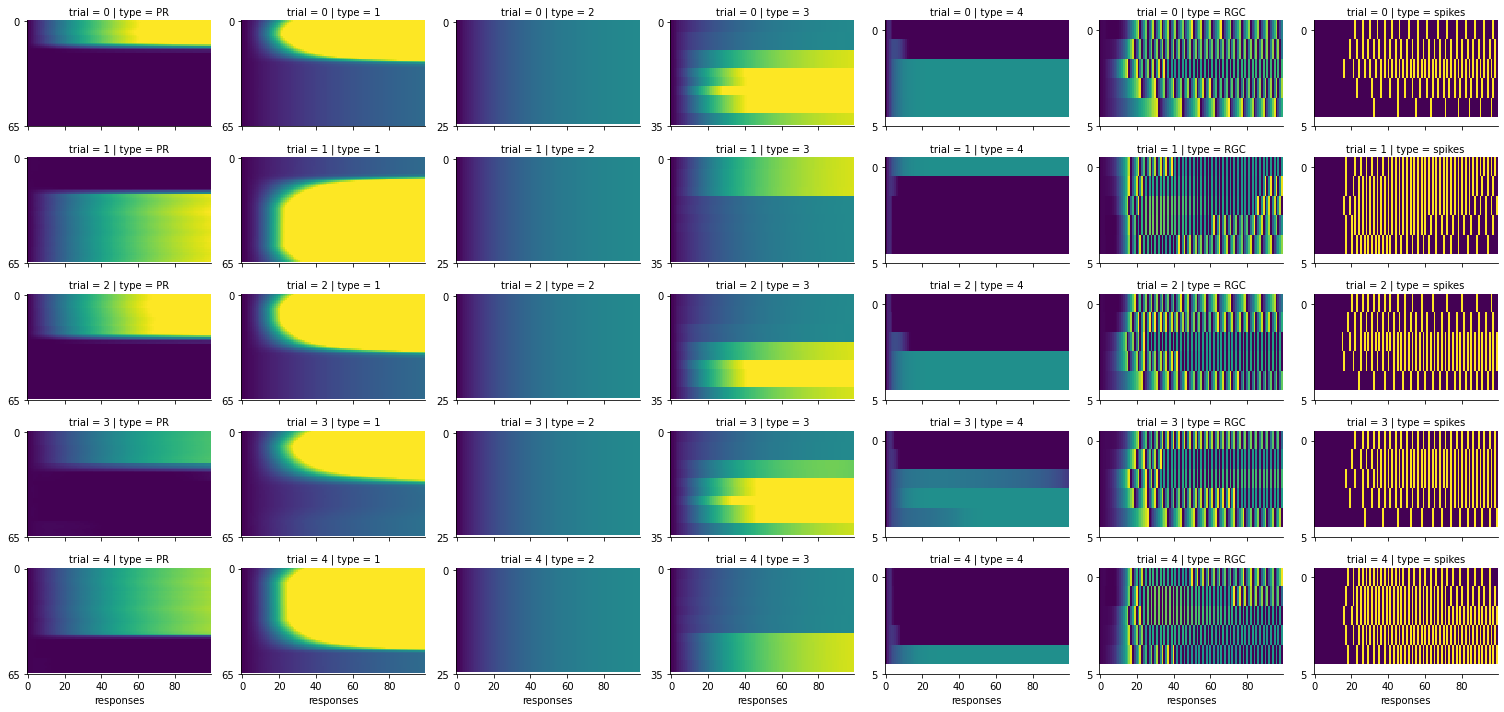

In [31]:
plot_elite_response(elites0, 0, -1, path1)

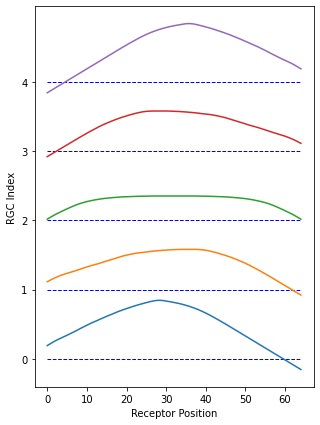

In [32]:
plot_elite_response_profile(elites0, 0, -1, path1)

In [33]:
np.save(os.path.join(path1, 'scores.npy'), scores0)
for i, ei in enumerate(elites0):
    for j, eij in enumerate(ei):
        eij.to_csv(os.path.join(path1, 'elite%d_%d' % (i, j)))

In [9]:
t = 50
n = 30
l = np.zeros((n, t))
for i in range(n):
    for ti in range(1, t):
        x, y = generate(TRAIN + TEST)
        m = MLPRegressor(solver='lbfgs', alpha=1e-5, learning_rate_init=0.01, max_iter=ti, 
                         hidden_layer_sizes=(x.shape[1]//2,))
        m = m.fit(x[:TRAIN], y[:TRAIN])

        l[i, ti] = m.score(x[TRAIN:], y[TRAIN:])


/home/zigon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/zigon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/zigon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

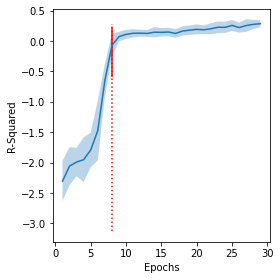

In [14]:
m = l[:, 1:30].mean(axis=0)
std = l[:, 1:30].std(axis=0)
x = np.arange(1, 30)
fig, ax = plt.subplots(1, figsize=(4, 4))
ax.plot(x, m)
ax.fill_between(x, m - std, m + std, alpha=0.3)
ax.set_xlabel('Epochs')
ax.set_xticks(np.arange(0, t, 5))
ax.set_ylabel('R-Squared')
n = 8
ax.vlines(n, l.min(), m.max(), color='r', linestyle=':')
ax.vlines(n, l[:, n].min(), l[:, n].max(), color='r')
fig.tight_layout()
# fig.savefig('../images/weak_perceptron.pdf')

In [7]:
def read(fname):
    def convert_list(v):
        if len(v) < 2:
            return np.nan
        elif len(v) == 2:
            return []
        else:
            return list(map(int, v[1:-1].split(', ')))
    
    e = pd.read_csv(fname, index_col=0, 
                    converters={'to': convert_list})
    
    return e

      n  a_a  b_a  a_d  b_d  axon  dend   tau         to
0  60.0  0.6  2.5  0.2  1.5   1.0  -1.0   5.0  [3, 2, 1]
1  60.0  1.0  2.5  0.6  1.5   1.0  -1.0   5.0     [3, 2]
2   5.0  1.0  0.5  1.0  1.5   1.0   1.0   5.0     [0, 3]
3   5.0  0.6  2.5  1.0  0.5  -1.0   1.0  25.0         []
4   NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN        NaN
5   NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN        NaN
6   NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN        NaN


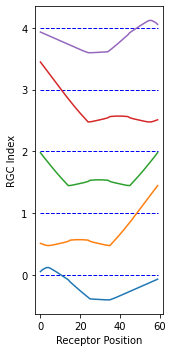

In [22]:
e = read('no_rand/ni_40_40_5_15_3/elite339_0')
print(e)
plot_elite_response_profile([[e]], 0, 0, 'erp1')